# Milestone 6 solution:  Predictions in 2020 and generalization to other cities
 
## Objective
 
- In 2020 society was strongly impacted by city wide lockdown due to COVID19 pandemic. We
  need to ensure that the model still makes sensible predictions.
  In addition, now that we have a model for safety events in San-Francisco, we would like to 
  generalize it to a few other US cities (New-York, Chicago)
  
 
## Requirements
 
Install the Python package that we have created in our previous milestone, which contains some of the useful functions,

In [1]:
! pip install --upgrade https://public-sym.s3-eu-west-1.amazonaws.com/LP-safety-US-cities/safety-events-cities-0.3.tar.gz

  Using cached https://public-sym.s3-eu-west-1.amazonaws.com/LP-safety-US-cities/safety-events-cities-0.3.tar.gz (2.2 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for safety-events-cities: filename=safety_events_cities-0.3-py3-none-any.whl size=2620 sha256=ebcb785166880f510fe213c66e1ff13837f9046d76548973deab9deaad33cdd5
  Stored in directory: /home/rth/.cache/pip/wheels/94/9c/d3/faf40b894b21bd985b7dc734f27dfcb9516f879ede1bb2684c
Successfully built safety-events-cities
  Attempting uninstall: safety-events-cities
    Found existing installation: safety-events-cities 0.3
    Uninstalling safety-events-cities-0.3:
      Successfully uninstalled safety-events-cities-0.3


In [2]:
# this plugin requires to run "pip install nb-black"
%load_ext nb_black

# Reload modules automatically when importing code
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

We start by listing most frequent categories, for future reference,

In [4]:
df0 = pd.read_parquet("../data/safety-SanFrancisco-2.parquet")
df0["category"].value_counts().head(8)

Street and Sidewalk Cleaning    965968
Potentially Life-Threatening    676296
Non Life-threatening            349634
Alarm                           326893
Graffiti                        296927
Encampments                     239275
Parking Enforcement             153902
Abandoned Vehicle               124820
Name: category, dtype: int64

<IPython.core.display.Javascript object>

## 3. Predictions in 2020

### 1.1. Visualization

Let's compare the safety event frequency between 2019 and 2020 to see if city wide lockdowns might have had an impact.

In [5]:
from safety_events_cities.milestone3 import load_data

category = "Street and Sidewalk Cleaning"

df = load_data(
    "../data/safety-SanFrancisco-2.parquet",
    category=category,
    years=[2018, 2019, 2020],
)

df.head()

,dateTime,neighborhood,count
0,2018-01-01,Ingleside,32
1,2018-01-01,Mission,72
2,2018-01-01,Nob Hill,46
3,2018-01-01,SoMa,47
4,2018-01-01,Tenderloin,42


<IPython.core.display.Javascript object>

We aggregate safety events for each neighborhood by week to make visualization less noisy and more readable,

(17896.0, 18444.0)

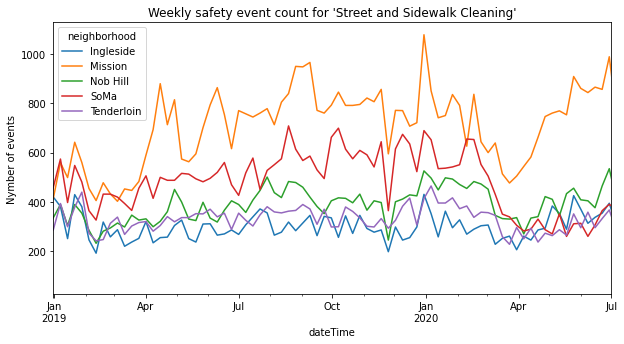

<IPython.core.display.Javascript object>

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))

df.groupby([pd.Grouper(key="dateTime", freq="7D"), "neighborhood"])[
    "count"
].sum().unstack().plot(ax=ax)

ax.set_title(f"Weekly safety event count for '{category}'")
ax.set_ylabel("Nymber of events")
ax.set_xlim(pd.Timestamp("2018-12-31"), pd.Timestamp("2020-07-01"))

If we compare the number of safety events beginning of 2020 for "Street and Sidewalk Cleaning", to the same months in 2019 we observe,
 - for the Mission Neighborhood a significant drop in the number of events mid March until mid April 2020. This could correspond to the dates of city lockdown. We see that in May activity returns to the previous values.
 - for the South of Market (SoMa) a 40% drop in the number of events, that remain at this level until July. This neighborhood contains in particular software companies and warehouses that may have not returned to the previous level of on-site activity even after the end of the lockdown.
 
It should be noted that a decrease in the number of reported events could indicate either or both the decrease in the actual number of events or the decrease in the people reporting them.


### 1.1. Model evaluation

To evaluate how reliable our model would be for this time period, we make a train/test split such as to include the first half of 2020 in the test set. 

In [7]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(
    df.sort_values("dateTime"), test_size=0.20, shuffle=False
)

<IPython.core.display.Javascript object>

In [8]:
print("Train:", df_train["dateTime"].min(), "-", df_train["dateTime"].max())
print("Test:", df_test["dateTime"].min(), "-", df_test["dateTime"].max())

Train: 2018-01-01 00:00:00 - 2020-01-11 00:00:00
Test: 2020-01-11 00:00:00 - 2020-07-14 00:00:00


<IPython.core.display.Javascript object>

Here, we adapt the model from Milestone 3 and 4, for now without external features for simplicity.

In [9]:
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer

from sklearn.experimental import enable_hist_gradient_boosting  # noqa

from sklearn.ensemble import HistGradientBoostingRegressor
from safety_events_cities.milestone3 import encode_timestamp

column_transformer_ord = ColumnTransformer(
    [
        ("cat", OrdinalEncoder(), ["neighborhood"],),
        (
            "passthrough",
            "passthrough",
            ["month", "day", "dayofweek", "hour", "dayofyear", "year",],
        ),
    ]
)

est_gb = HistGradientBoostingRegressor(max_depth=4, loss="poisson", learning_rate=0.05)

pipe_model = make_pipeline(
    FunctionTransformer(encode_timestamp), column_transformer_ord, est_gb
)
pipe_model.fit(
    df_train, df_train["count"],
)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function encode_timestamp at 0x7f07380749e0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                                  ['neighborhood']),
                                                 ('passthrough', 'passthrough',
                                                  ['month', 'day', 'dayofweek',
                                                   'hour', 'dayofyear',
                                                   'year'])])),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(learning_rate=0.05,
                                               loss='poisson', max_depth=4))])

<IPython.core.display.Javascript object>

With a model trained on 2017-2019 data we then compute the RMSE score on the test set for each 15 days period between January and July 2020,

In [11]:
from sklearn.metrics import mean_squared_error
from functools import partial


def _evaluate_rmse_score(model, df_s):
    y_true = df_s["count"]
    y_pred = model.predict(df_s)
    return mean_squared_error(y_true, y_pred, squared=False)


res = (
    df_test.groupby([pd.Grouper(key="dateTime", freq="15d"), "neighborhood"])
    .apply(partial(_evaluate_rmse_score, pipe_model))
    .unstack()
    .round(1)
)
print("Weekly RMSE")
display(res)
print("Average RMSE")
res.mean(axis=0).T

Weekly RMSE


neighborhood,Ingleside,Mission,Nob Hill,SoMa,Tenderloin
dateTime,,,,,
2020-01-11,13.2,19.4,17.7,19.4,14.1
2020-01-26,12.1,23.2,13.2,16.5,8.1
2020-02-10,10.6,30.3,11.8,22.0,8.6
2020-02-25,9.4,24.7,13.6,17.0,9.7
2020-03-11,11.6,24.7,15.9,31.2,18.1
2020-03-26,13.9,32.6,21.5,41.8,16.2
2020-04-10,9.4,34.0,19.8,44.6,15.3
2020-04-25,14.1,23.8,14.8,48.5,16.5
2020-05-10,11.8,17.5,14.8,42.9,14.7


Average RMSE


neighborhood
Ingleside     12.961538
Mission       27.861538
Nob Hill      15.900000
SoMa          34.953846
Tenderloin    13.569231
dtype: float64

<IPython.core.display.Javascript object>

We notice that while for the majority of neighborhoods the RMSE error is comparable between different months, for SoMa neighborhood there was a 2x increase in RMSE after May 2020. This phenomena is known as a [concept drift](https://en.wikipedia.org/wiki/Concept_drift) which leads to worse model accuracy over time, and in the following section we will attempt to mitigate this issue.

### 1.2. Mitigating the concept drift

Concept drift occurs when the statistical property of the target variable change over time in unknown ways. Two typical approaches to mitigate this issue consist in either,
 1. monitoring model accuracy and re-training the model with new data when a significant degradation is observed
 2. or simply periodically re-training the model on new data.
 
We can model the second approach with a time-series cross-validation, where a sufficient number of folds are used to make the validation span a 15 days period. The test set is then all the historical data prior to the beginning of the validation set.

The weekly RMSE with this approach is outlined in the below table,

In [12]:
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

cv = TimeSeriesSplit(n_splits=60)


def _cross_val_eval(model, cv, df):
    out = []
    index = []

    for train_idx, test_idx in cv.split(df.sort_values("dateTime")):
        df_train, df_test = df.iloc[train_idx], df.iloc[test_idx]
        if df_test["dateTime"].min() < pd.Timestamp("2020-01-01"):
            continue

        pipe_model.fit(
            df_train, df_train["count"],
        )

        out.append(
            df_test.groupby("neighborhood").apply(partial(_evaluate_rmse_score, model))
        )
        print(
            "Evaluating with test set: ",
            df_test["dateTime"].min(),
            "-",
            df_test["dateTime"].max(),
        )
        index.append(df_test["dateTime"].mean())

    return pd.concat(out, axis=1, keys=index).T.round(2)


res = _cross_val_eval(pipe_model, cv, df)
print("Weekly RMSE")
display(res)
print("Average RMSE")
res.mean(axis=0)

Evaluating with test set:  2020-01-02 00:00:00 - 2020-01-16 00:00:00
Evaluating with test set:  2020-01-17 00:00:00 - 2020-01-31 00:00:00
Evaluating with test set:  2020-02-01 00:00:00 - 2020-02-15 00:00:00
Evaluating with test set:  2020-02-16 00:00:00 - 2020-03-01 00:00:00
Evaluating with test set:  2020-03-02 00:00:00 - 2020-03-16 00:00:00
Evaluating with test set:  2020-03-17 00:00:00 - 2020-03-31 00:00:00
Evaluating with test set:  2020-04-01 00:00:00 - 2020-04-15 00:00:00
Evaluating with test set:  2020-04-16 00:00:00 - 2020-04-30 00:00:00
Evaluating with test set:  2020-05-01 00:00:00 - 2020-05-15 00:00:00
Evaluating with test set:  2020-05-16 00:00:00 - 2020-05-30 00:00:00
Evaluating with test set:  2020-05-31 00:00:00 - 2020-06-14 00:00:00
Evaluating with test set:  2020-06-15 00:00:00 - 2020-06-29 00:00:00
Evaluating with test set:  2020-06-30 00:00:00 - 2020-07-14 00:00:00
Weekly RMSE


neighborhood,Ingleside,Mission,Nob Hill,SoMa,Tenderloin
2020-01-09,14.00,57.92,26.82,33.40,19.07
2020-01-24,13.13,22.34,15.53,15.86,15.73
2020-02-08,10.56,17.18,13.49,23.31,8.63
2020-02-23,12.06,22.50,14.84,23.55,9.84
2020-03-09,10.33,32.99,13.58,23.84,12.22
2020-03-24,9.21,22.71,11.45,21.58,15.24
2020-04-08,12.90,22.71,16.94,32.83,13.65
2020-04-23,9.72,16.23,9.94,28.38,12.89
2020-05-08,16.17,20.07,12.86,29.78,12.94
2020-05-23,11.97,20.93,12.81,26.34,7.16


Average RMSE


neighborhood
Ingleside     12.498462
Mission       27.318462
Nob Hill      14.579231
SoMa          24.867692
Tenderloin    12.327692
dtype: float64

<IPython.core.display.Javascript object>

While overall the RMSE scores are comparable to those obtained previously, we notice a significant decrease of RSME error for SoMa as we are better able to account for the concept drift in the model.

**Note:** we could also use `sample_weight` fit parameter to weight higher more recent observations during training, however the `HistGradientBoostingRegressor` model does not (yet) support `sample_weight` in scikit-learn 0.23.


## 2. Generalizing the ML model to other US cities

As we saw in Milestone 2 the layout of the available safety events data is very similar between San-Francisco, New York City and Chicago. Most of the processing steps should therefore apply irrespective of the city.

One major difference is that the categories of events are not identical, and we would therefore need to train one ML model per city (and event category). We certainly won't be able to train a model for one city and apply it directly to a different city, due to the target variable being different and the neighborhood being used as an input variable.

An outline of steps necessary to extend the obtained model for other cities is presented below. We won't have time to implement it in this milestone.
 1. Re-run analysis from milestone 2 to ensure than intuitions and data understanding we obtained for San-Fransisco still applies to other cities.
 2. Compute the neighborhood of each event using the GeoJSON files provided in the milestone 6 description. At this stage we should likely use proper geo-spatial software for this operation such as [geopandas](https://geopandas.org/)
 3. Re-train and evaluate the model enhanced with external data from Milestone 4. This should likely not require any pipeline modification since both external weather data and holiday schedules is available for all 3 cities.
 4. Finally, re-run hyper-parameter search and model validation and interpretation tools.
 
The main requirement for implementing these steps is a well organized code base, to allow quickly switching the modeling between different cities. We would need to move most of the code into a separate Python package created in Milestone 3, document it and add unit tests to ensure code correctness. 

## 3. Project summary and next steps

In this project we have started by analyzing San-Francisco safety events data, and designed a machine learning model to predict the number of events per neighborhood. We have investigated how to reduce the prediction error by enhancing the training set with external data, including weather observation and public holidays. We searched for optimal model hyper-parameters and explored some classical model interpretability tools.


Following points could deserve further investigation, 
 - Analyzing the relationship between the frequency of reported safety events and occurred events. It appears that some events may never be reported, while other (e.g. a fire) are reported multiple times. Although we have de-duplication step in the processing, this discrepancy can have a significant impact on modeling as it means that we only have data for a proxy of the target variable.
 - So far we have chosen to aggregate safety events with a 1 day granularity. Finer granularity (e.g. of a few hours) would likely be more useful for practical applications. However it would also likely include more noise and would be more difficult to visualize and evaluate due to its multi-scale nature ranging from hour or month time-scales.
 - We have mostly focused on machine learning models in this project, while it could also be useful to compare predictions with classical time series forecasting models.
 - Currently, we train one model per city and category on a relatively small resulting number of samples in the historical data. As the number of cities increases, it it would be interesting to consider whether we could standardize the category scheme and train a single model with training data from all cities simultaneously.